### Visualizing the distribution of the observations

### Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math
%pylab inline

import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from computeStats import computeOverAllDist, STAT_Descriptions

### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='BBSBSBSB'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print 'keys from STAT=',STAT.keys()

#read data
filename=data_dir+'/US_Weather_%s.parquet'%file_index

df=sqlContext.read.parquet(filename)
print df.count()
df.show(5)

Populating the interactive namespace from numpy and matplotlib
keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']
12493
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    20|[00 7E 40 D2 00 D...|1898.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    31|[30 D4 80 D4 30 D...|1900.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 7E 00 7E A0 D...|1901.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    32|[00 7E 00 7E 00 7...|1902.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       TMAX|USC00219059|    28|[00 00 00 D3 30 D...|1903.0|BBSBSBSB|
+---------+--------+---------+-----------+-----------+------+-------------

### Select data for a particular station and measurement type

In [3]:
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT * FROM weather\n\tWHERE measurement='%s' and station='%s'"%('PRCP','USC00219059')
print Query
df1 = sqlContext.sql(Query)
print df1.count(),'rows'
df1.show(2)
rows=df1.rdd.map(lambda row:unpackArray(row['vector'],np.float16)).collect()
T=np.vstack(rows)
T=T/10.  # scaling to make the temperature be in centingrates
shape(T)

SELECT * FROM weather
	WHERE measurement='PRCP' and station='USC00219059'
114 rows
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|elevation|latitude|longitude|measurement|    station|undefs|              vector|  year|   label|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
|    400.8| 47.4306| -94.0586|       PRCP|USC00219059|     1|[00 00 00 00 00 0...|1895.0|BBSBSBSB|
|    400.8| 47.4306| -94.0586|       PRCP|USC00219059|    23|[00 00 00 00 00 0...|1898.0|BBSBSBSB|
+---------+--------+---------+-----------+-----------+------+--------------------+------+--------+
only showing top 2 rows



(114, 365)

### Script for plotting yearly plots

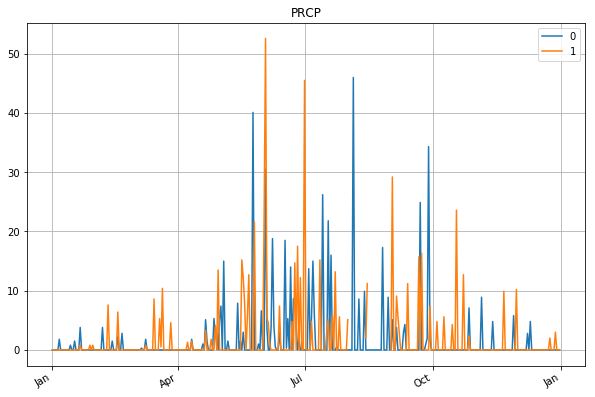

In [4]:
from YearPlotter import YearPlotter
fig, ax = plt.subplots(figsize=(10,7));
YP=YearPlotter()
YP.plot(T[:2,:].transpose(),fig,ax,title='PRCP')
#title('A sample of graphs');

### Distribution of missing observations
The distribution of missing observations is not uniform throughout the year. We visualize it below.

In [22]:
def plot_pair(pair,func):
    j=0
    fig,X=subplots(1,2,figsize=(16,6))
    axes=X.reshape(2)
    for m in pair:
        axis = axes[j]
        j+=1
        func(m,fig,axis)
        
def plot_valid(m,fig,axis):
    valid_m=STAT[m]['NE']
    YP.plot(valid_m,fig,axis,title='valid-counts '+m)

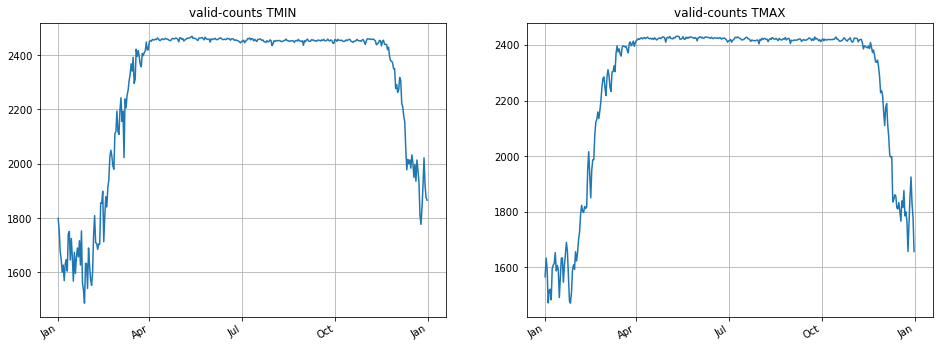

In [23]:
plot_pair(['TMIN','TMAX'],plot_valid)

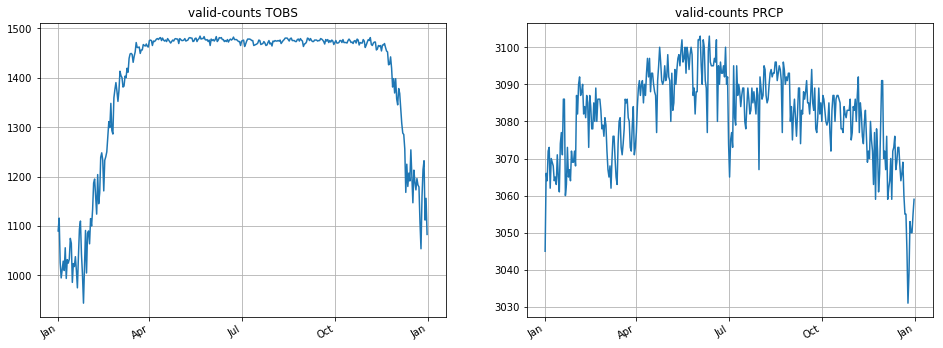

In [14]:
plot_pair(['TOBS','PRCP'],plot_valid)

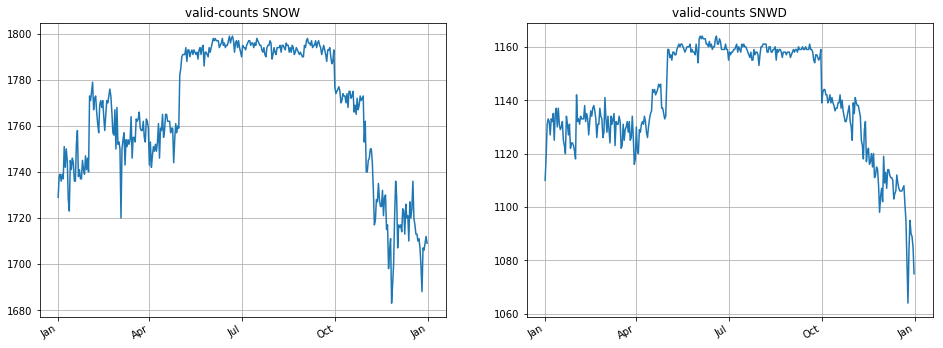

In [15]:
plot_pair(['SNOW', 'SNWD'],plot_valid)

### Plots of mean and std of observations

In [115]:
def plot_mean_std(m,fig,axis):
    mean=STAT[m]['Mean']
    std=np.sqrt(STAT[m]['Var'])
    graphs=np.vstack([mean]).transpose()*3.# divide by 10 for temp
    YP.plot(graphs,fig,axis,title='Mean   '+m,labels=['mean'])

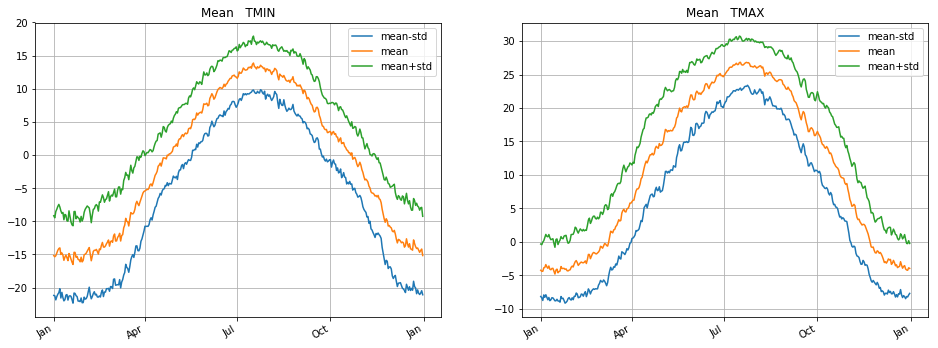

In [114]:
plot_pair(['TMIN','TMAX'],plot_mean_std)


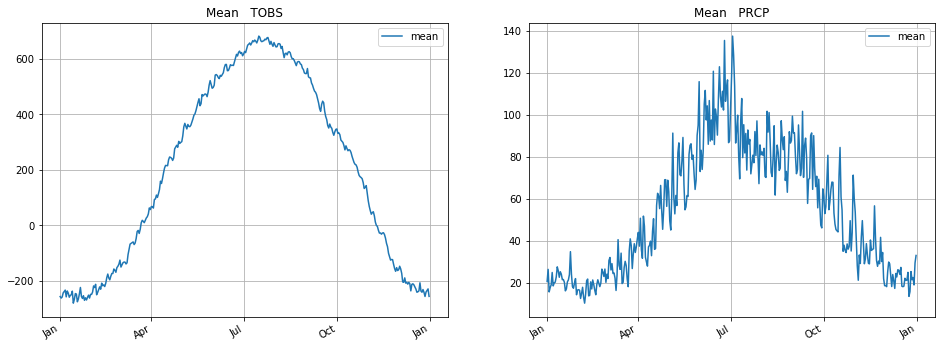

In [116]:
plot_pair(['TOBS','PRCP'],plot_mean_std)

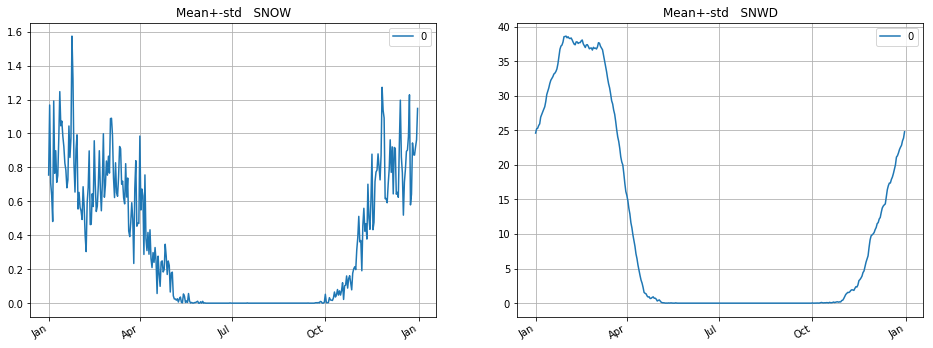

In [87]:
plot_pair(['SNOW', 'SNWD'],plot_mean_std)

### plotting top 3 eigenvectors

In [138]:
def plot_eigen(m,fig,axis):
    EV=STAT[m]['eigvec']
    YP.plot(EV[:,:4],fig,axis,title='Top Eigenvectors '+m)

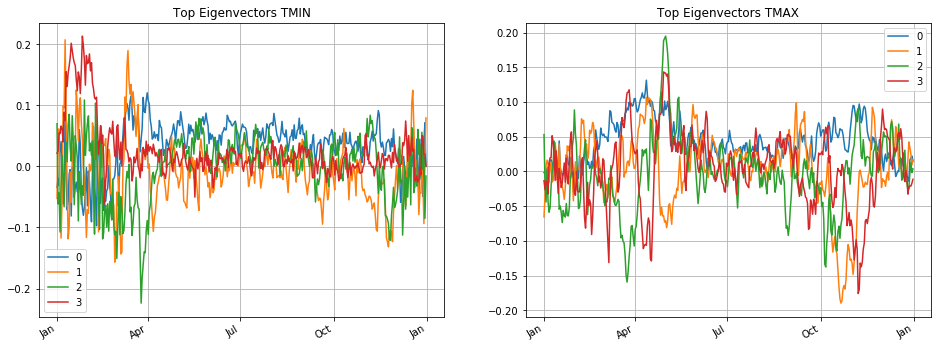

In [139]:
plot_pair(['TMIN','TMAX'],plot_eigen)

In [149]:
aM = STAT['SNOW']['Mean']
bM = STAT['SNWD']['Mean']
print numpy.corrcoef(aM,bM)

[[ 1.          0.78637037]
 [ 0.78637037  1.        ]]


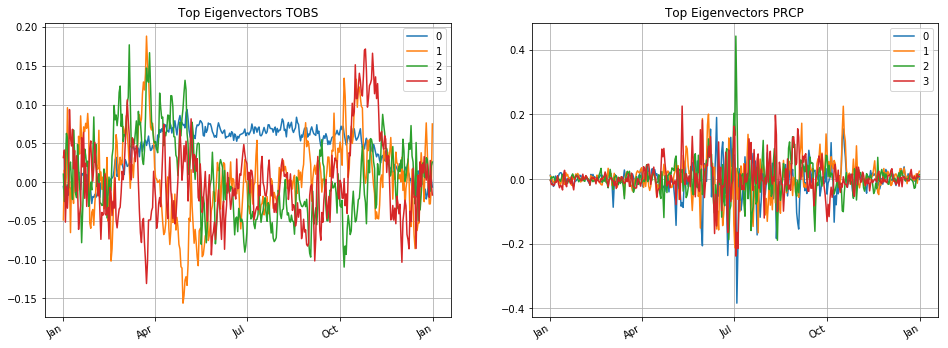

In [140]:
plot_pair(['TOBS','PRCP'],plot_eigen)

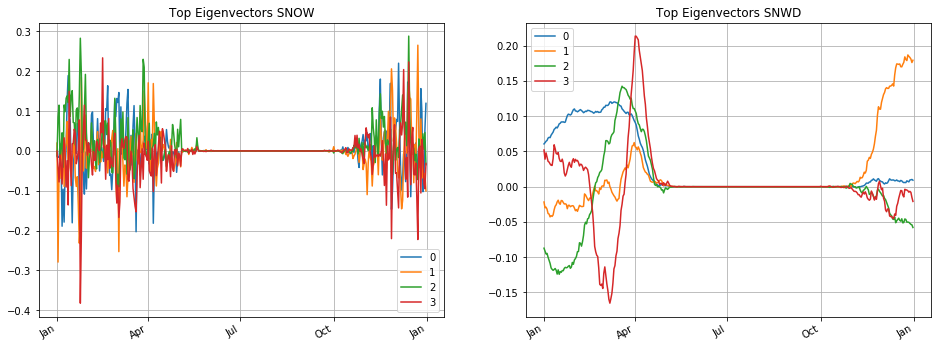

In [141]:
plot_pair(['SNOW', 'SNWD'],plot_eigen)

### Script for plotting percentage of variance explained

In [135]:
def pltVarExplained(j):
    subplot(1,3,j)
    EV=STAT[m]['eigval']
    k=100
    plot(([0,]+list(cumsum(EV[:k])))/sum(EV))
    title('Percentage of Variance Explained for '+ m)
    ylabel('Percentage of Variance')
    xlabel('# Eigenvector')
    grid()
    

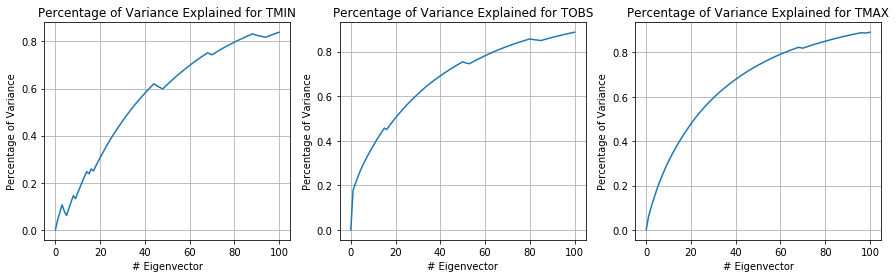

In [136]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['TMIN', 'TOBS', 'TMAX']: #,
    pltVarExplained(j)
    j+=1

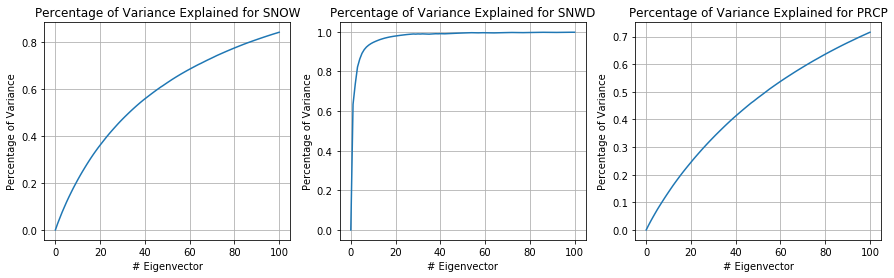

In [137]:
f=plt.figure(figsize=(15,4))
j=1
for m in ['SNOW', 'SNWD', 'PRCP']:
    pltVarExplained(j)
    j+=1 

In [ ]:
#sc.stop()